# Inference - classifier

In [1]:
! rsync -a /kaggle/input/mmdetection-v280/mmdetection /
! pip install /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
! pip install /kaggle/input/hpapytorchzoo/pytorch_zoo-master/
! pip install /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation/
! pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

! cp -r /kaggle/input/kgl-humanprotein-data/kgl_humanprotein_data /
! cp -r /kaggle/input/humanpro/kgl_humanprotein /

%cd /kgl_humanprotein/nbs/
import sys
sys.path.append('/kgl_humanprotein/')

Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272915 sha256=d737e3007986930038fac4c24aaf1a17402c64355a97384916fa277ae17fb83f
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
Processing /kaggle/input/hpapytorchzoo/pytorch_zoo-master
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=80d6ae56a8e534e43f4a61f6a040070857adc6ced1b9e444d5b75a860c231e92
  Stored in directory: /root/.cache/pip/wheels/7f/18/21/aff5a8914e22461b2b025a9629c2b70464c36183caaf12bc09
Successfully built pytorch-zoo
Processing /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14815 sha256=7f3a64b8de6eb42130c2e882b09ce409435439b6c237726019ec26b1308be905
  Stored in di

In [2]:
from pathlib import Path
import shutil
import tqdm
import zipfile
import zlib 
import base64
import itertools
import numpy as np
import pandas as pd
import cv2
from pycocotools import mask as mutils
from pycocotools import _mask as coco_mask
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

from kgl_humanprotein.utils.common_util import *
from kgl_humanprotein.datasets.tool import image_to_tensor
from kgl_humanprotein.config.config import *
from kgl_humanprotein.data_process import *
from kgl_humanprotein.networks.imageclsnet import init_network
from kgl_humanprotein.run.test import *

run on 1d98aa0ee438


In [3]:
dir_kaggle_inp = Path('/kaggle/input')
dir_kaggle_out = Path('/kaggle/working')

dir_hpa = dir_kaggle_inp/'hpa-single-cell-image-classification'
dir_test = dir_hpa/'test'

In [4]:
out_dir = ('external_crop256_focal_slov_hardlog_class'
           '_densenet121_dropout_i384_aug2_5folds')
seeds = '0'
fold = 0
predict_epoch = None
augment = 'default'

## Plotting functions

In [5]:
def plt_image(ax, img, bmask=None, centres=None, texts=None):
    ax.imshow(img[...,:3])
    if bmask is not None:
        ax.imshow(bmask, cmap='cividis', alpha=.5)
    
    if (centres is not None) and (texts is not None):
        for centre, text in zip(centres, texts):
            x, y = centre
            ax.text(x, y, text, color='cyan')
    
    return ax

## Model

In [6]:
%%time
shutil.rmtree(RESULT_DIR)
shutil.copytree(dir_kaggle_inp/'humanpro-classifier'/'result', RESULT_DIR)

CPU times: user 195 ms, sys: 1.88 s, total: 2.07 s
Wall time: 18.2 s


PosixPath('../../kgl_humanprotein_data/result')

In [7]:
arch = 'class_densenet121_dropout'

In [8]:
predict_epoch = 'final' if predict_epoch is None else '%03d' % predict_epoch
network_path = RESULT_DIR/'models'/out_dir/f'fold{fold:d}'/f'{predict_epoch}.pth'

In [9]:
def load_model(network_path, arch='class_densenet121_dropout', 
               num_classes=19, in_channels=4):
    model_params = {}
    model_params['architecture'] = arch
    model_params['num_classes'] = num_classes
    model_params['in_channels'] = in_channels
    model = init_network(model_params)

    checkpoint = torch.load(network_path)
    model.load_state_dict(checkpoint['state_dict'])
    model = nn.DataParallel(model)
    model.to(DEVICE)
    model.eval()
    return model

In [10]:
model = load_model(network_path, arch=arch)

>> Using pre-trained model.


## HPA Cell Segmentator

In [11]:
# dir_segmentator_models = Path(
#     '/kaggle/input/hpacellsegmentationmodels/hpa-cell-segmentation-models/')

# segmentator = load_segmentator(dir_segmentator_models, padding=True)

In [12]:
!pip install -q "/kaggle/input/hpacellsegmentatormaster/HPA-Cell-Segmentation-master"
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell
NUC_MODEL = '/kaggle/input/hpacellsegmentatormodelweights/dpn_unet_nuclei_v1.pth'
CELL_MODEL = '/kaggle/input/hpacellsegmentatormodelweights/dpn_unet_cell_3ch_v1.pth'

segmentator = cellsegmentator.CellSegmentator(NUC_MODEL, CELL_MODEL, scale_factor=0.25, padding=True)

please compile abn


## Test Data

In [13]:
imgids = list(pd.read_csv(dir_hpa/'sample_submission.csv')['ID'].values)

if len(imgids) == 559:
    debug = True
    imgids = imgids[:20] #list(np.random.choice(imgids, 10))

In [14]:
class ProteinTestDataset(Dataset):
    def __init__(self, images, img_size=512, transform=None, 
                 crop_size=0, random_crop=False):
        self.images = images
        self.img_size = img_size
        self.transform = transform
        self.crop_size = crop_size
        self.random_crop = random_crop
        self.num = len(self.images)

    def read_crop_img(self, img):
        random_crop_size = int(np.random.uniform(self.crop_size, self.img_size))
        x = int(np.random.uniform(0, self.img_size - random_crop_size))
        y = int(np.random.uniform(0, self.img_size - random_crop_size))
        crop_img = img[x:x + random_crop_size, y:y + random_crop_size]
        return crop_img

    def read_rgby(self, index):
        img = self.images[index]
        if self.random_crop and self.crop_size > 0:
            img = self.read_crop_img(img)
        return img

    def __getitem__(self, index):
        image = self.read_rgby(index)

        h, w = image.shape[:2]
        if self.crop_size > 0:
            if self.crop_size != h or self.crop_size != w:
                image = cv2.resize(image, (self.crop_size, self.crop_size), interpolation=cv2.INTER_LINEAR)
        else:
            if self.img_size != h or self.img_size != w:
                image = cv2.resize(image, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)

        if self.transform is not None:
            image = self.transform(image)
        image = image / 255.0
        image = image_to_tensor(image)
        return image, index

    def __len__(self):
        return self.num

## Inference

In [15]:
def image_predict(dl, model, threshold=0.5):
    '''
    Predict on an image.
    '''
    with torch.no_grad():
        images, indices = next(iter(dl))
        assert len(images) == len(indices) == len(dl.dataset)
        images = Variable(images.to(DEVICE), volatile=True)
        outputs = model(images)
        logits = outputs
        probs = F.sigmoid(logits).data
    probs[range(len(probs)), probs.argmax(axis=1)] = .95
    assert len(probs) == len(dl.dataset)
    preds = [torch.where(prob > threshold)[0] for prob in probs]
    confs = [prob[pred] for pred, prob in zip(preds, probs)]
    return preds, confs    


def image_submitstring(imgid=None, img=None, bmasks=None, preds=None, confs=None):
    '''
    Form submission string for an image.
    '''
    enrles = [encode_binary_mask(bmask.astype(bool))for bmask in bmasks]
    predstring = ' '.join(f'{p} {c:.4f} {enrle}' 
                          for pred, conf, enrle in zip(preds, confs, enrles) 
                          for p, c in zip(list(pred), conf))
    submitstring = f'{imgid}, {img.shape[1]}, {img.shape[0]}, {predstring}'
    return submitstring


def binary_mask_to_ascii(mask, mask_val=1):
    """Converts a binary mask into OID challenge encoding ascii text."""
    mask = np.where(mask==mask_val, 1, 0).astype(np.bool)
    
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(f"encode_binary_mask expects a binary mask, received dtype == {mask.dtype}")

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(f"encode_binary_mask expects a 2d mask, received shape == {mask.shape}")

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode()


def image_submitstring_1(imgid=None, img=None, mask=None, preds=None, confs=None):
    enrles = [binary_mask_to_ascii(mask, mask_val=cell_id) for cell_id in range(1, mask.max()+1)]
    predstring = ' '.join(f'{p} {c:.4f} {enrle}' 
                          for pred, conf, enrle in zip(preds, confs, enrles) 
                          for p, c in zip(list(pred), conf))
    submitstring = f'{imgid}, {img.shape[1]}, {img.shape[0]}, {predstring}'
    print(enrles[0][:10], len(enrles[0]))
    return submitstring


def segment_batch_image(batch_rgby_images):
    cell_segmentations = segmentator.pred_cells([[rgby_image[...,j] for rgby_image in batch_rgby_images] for j in [0, 3, 2]])
    nuc_segmentations = segmentator.pred_nuclei([rgby_image[...,2] for rgby_image in batch_rgby_images])
    batch_masks = [label_cell(nuc_seg, cell_seg)[1].astype(np.uint8) 
                   for nuc_seg, cell_seg in zip(nuc_segmentations, cell_segmentations)]
    return batch_masks

In [16]:
sz_img = 200
sz_crop = 128
bs = 8

threshold = 0.0

num_workers = 3
pin_memory = True

In [17]:
with open('submission.csv', mode='w') as file_submit:
    print('ID, ImageWidth, ImageHeight, PredictionString', file=file_submit)
    
    for i_batch in tqdm.tqdm(range(0, len(imgids), bs), total=len(imgids)//bs):
        batch_imgid = imgids[i_batch:i_batch+bs]
        batch_img = [load_RGBY_image(dir_test, imgid) for imgid in batch_imgid]

#         batch_img_red    = [img[...,0] for img in batch_img]
#         batch_img_yellow = [img[...,3] for img in batch_img]
#         batch_img_blue   = [img[...,2] for img in batch_img]
#         masks = segmentator(batch_img_red, batch_img_yellow, batch_img_blue)
#         batch_mask = [mask_cell for mask_nucl, mask_cell in masks]
        batch_mask = segment_batch_image(batch_img)
        
        batch_rles   = [mask2rles(mask) for mask in batch_mask]
        batch_bmasks = [[mutils.decode(rle) for rle in rles] for rles in batch_rles]
        batch_bboxes = [rles2bboxes(rles) for rles in batch_rles]

        batch_cells = [[crop_image(img, bbox, bmask=bmask) for bbox, bmask in zip(bboxes, bmasks)] 
                       for img, bboxes, bmasks in zip(batch_img, batch_bboxes, batch_bmasks)]
        batch_cells = [[resize_image(pad_to_square(cell), sz_img) for cell in cells] for cells in batch_cells]

        batch_ds = [ProteinTestDataset(cells, img_size=sz_img, crop_size=sz_crop) for cells in batch_cells]
        batch_dl = [DataLoader(ds, sampler=SequentialSampler(ds), batch_size=len(ds),
                               drop_last=False, num_workers=num_workers, pin_memory=pin_memory) 
                    for ds in batch_ds]

        batch_preds, batch_confs = [], []
        for dl in batch_dl:
            preds, confs = image_predict(dl, model, threshold=threshold)
            batch_preds.append(preds)
            batch_confs.append(confs)

        batch_submitstring = [image_submitstring(imgid, img, bmasks, preds, confs) 
                              for imgid, img, bmasks, preds, confs 
                              in zip(batch_imgid, batch_img, batch_bmasks, batch_preds, batch_confs)]
        
        print('\n'.join(batch_submitstring), file=file_submit)

3it [03:26, 68.95s/it]


In [18]:
! cp submission.csv /kaggle/working/.

## Results visualisation

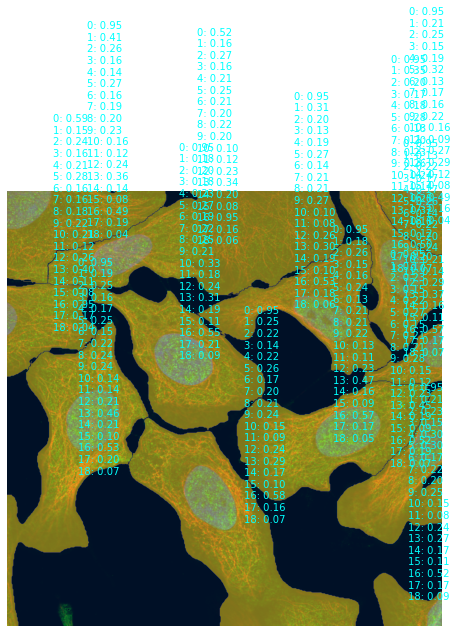

In [19]:
idx = 3

img = batch_img[idx]
bmasks = batch_bmasks[idx]
preds = batch_preds[idx]
confs = batch_confs[idx]
bboxes = batch_bboxes[idx]

texts = ['\n'.join(f'{p}: {c:.2f}' for p, c in zip(pred, conf)) 
         for pred, conf in zip(preds, confs)]
centres = [(0.5*(x0 + x1), 0.5*(y0 + y1)) for x0, y0, x1, y1 in bboxes]

fig, ax = plt.subplots(figsize=(8, 8))
bmask_total = np.stack(bmasks, axis=0).sum(axis=0)
ax = plt_image(ax, img, bmask=bmask_total, centres=centres, texts=texts)
ax.axis('off');

In [20]:
# fig, ax = plt.subplots(figsize=(5, 5))
# bmask_total = np.stack(bmasks, axis=0).sum(axis=0)
# ax = plt_image(ax, img, bmask=bmask_total, centres=None, texts=None)
# ax.axis('off');

# ncols = 6
# nrows = (len(cells) - 1) // ncols + 1
# fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2 * ncols, 2 * nrows))
# axs = axs.flatten()
# for ax in axs: 
#     ax.axis('off')
# for ax, cell in zip(axs, cells):
#     ax = plt_image(ax, cell[...,:3], )
# plt.tight_layout()

In [21]:
# def image_file_paths(dir_image, imgids):
#     colors = ['red', 'green', 'blue', 'yellow']
#     file_paths = [dir_image/f'{imgid}_{color}.png' for imgid in imgids for color in colors]
#     return file_paths


# pths = image_file_paths(dir_test, imgids)
# dst = dir_kaggle_out/'test'
# dst.mkdir(exist_ok=True, parents=True)

# for pth in pths:
#     shutil.copy(pth, dst/pth.name)

# %cd /kaggle/working

# ! zip -r test.zip test/